# Laplacian Eigenvalues #

Writen by: Oscar Reula (oreula@gmail.com)

This code is used to compute the resonant frequencies and eigenvectors of a cavity. The model is 2-dimensional, that is it corresponds to infinite long structures in the  ẑ direction. 
This restriction is mainly due to have a code that can run in home computers in very short time.

First the theory: we need to solve the following eigenfuntion problem: 

$\nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in $\Omega$}$

$u = 0 \text{ on $\partial\Omega$}$

Where $\Omega$ is some 2-dimensional region. 


In order to use finite elements we need to express the problem as a weak one:

$$
\int_{\Omega} \nabla u\,\cdot \nabla v\, {\rm d} x
= \lambda \int_{\Omega} u \cdot v\, {\rm d} x \quad \forall  v \in H^1_0(\Omega),
$$



We shall incorporate a simple, known, case which we shall use to test the implementation, namely:

$\nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in $\Omega$} \quad\quad\quad
\Omega = (0,\pi)\times(0,\pi)$

For this case we know the solutions: 

$u_{n,m}(x,y) = \sin(n x)\sin(m y), \quad \lambda = m^2 + n^2,$ $\quad \lambda = 2, 5, 5, 8, 10, 10, 13, 13, 17, 17, 18, \dots$

We use this case to check that what we are doing is correct. 

Part of this code is addapted from: https://gist.github.com/Balaje/102485bb14ec6daf677f938fbd8f3ebb

In [1]:
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
using gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack


## Mesh Generation ##

We shall use some meshes which will be contructed in a script to be included below.
It has several grids which can be modified via the parameters or directly modifying the script. 
In particular we have this grids:

**rectangle:**
We shall use a square mesh for testing and then several ones for experimenting: 

**square with a circular hole:**
A square with a circular hole in its interior. It is centered on the square, but then one can experiment moving it from the center. What would happend?

**circle with a circular hole:**
You can also move the hole here.

With the boolean assignments you can choose between cases.

In [2]:
test = false #square 
rectangle = false
square_circle = false
circle_circle = false

test = true #square 
#rectangle = true
#square_circle = true
#circle_circle = true


true

In [3]:
# Create mesh 
include("models/mesh_generator.jl")

make_model (generic function with 1 method)

In [4]:
L = 1
displacement = 0.0
h = 0.25

if test 
    grid_type = "test"
    p = (L*π,L*π, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0
elseif rectangle
    grid_type = "rectangle"
    p = (L*π,L*π+displacement, h) #for test / rectangle (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0
elseif square_circle
    grid_type = "square_circle"
    p = (π, π, 0.5*π, 0.5*π + displacement, 0.15*π, h) # for square_circle (Length_x, Length_y, circle_center_x, circle_center_y, radious)
    boundary_tags = ["circle", "ext"]
    dirichlet_tags= ["circle","ext"] 
    dirichlet_values = [0.0,0.0]
elseif circle_circle
    grid_type = "circle_circle"
    p = (0.0, 0.0, 0.5*π, 1.5*π, h) # for circle_circle (cy_center_x, cy_center_y, cy_inner_radious, cy_outer_radious)
    boundary_tags = ["inner","outer"]
    dirichlet_tags=["inner","outer"]
    dirichlet_values = [0.0,0.0]
end

model = make_model(grid_type, p)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000996828s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.013963s, CPU 0s)
Info    : 231 nodes 464 elements
Info    : Writing 'models/rectangle.msh'...
Info    : Done writing 'models/rectangle.msh'
Info    : Reading 'models/rectangle.msh'...
Info    : 9 entities
Info    : 231 nodes
Info    : 460 elements
Info    : Done reading 'models/rectangle.msh'


UnstructuredDiscreteModel()

We now define the triangulation and the measures, in the surface and in the boundary. Then plot them to make sure it is the region we want.

In [5]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

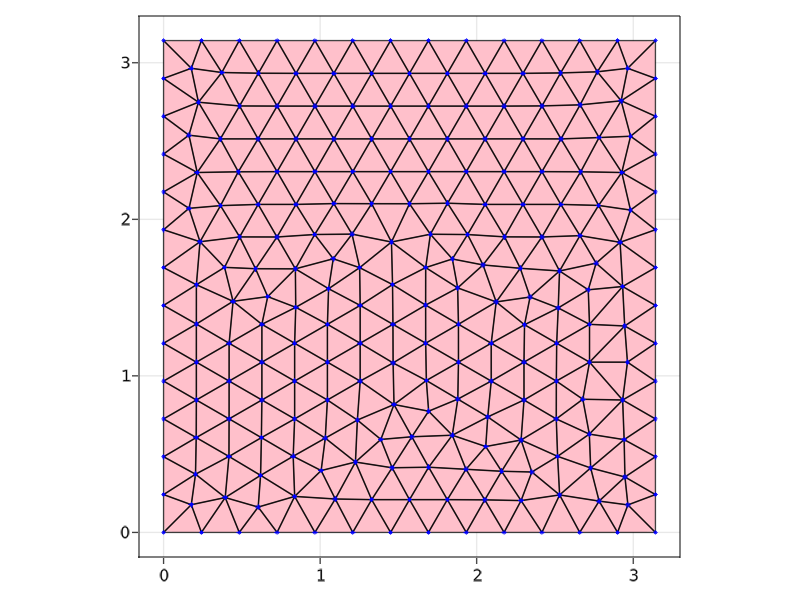

In [6]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

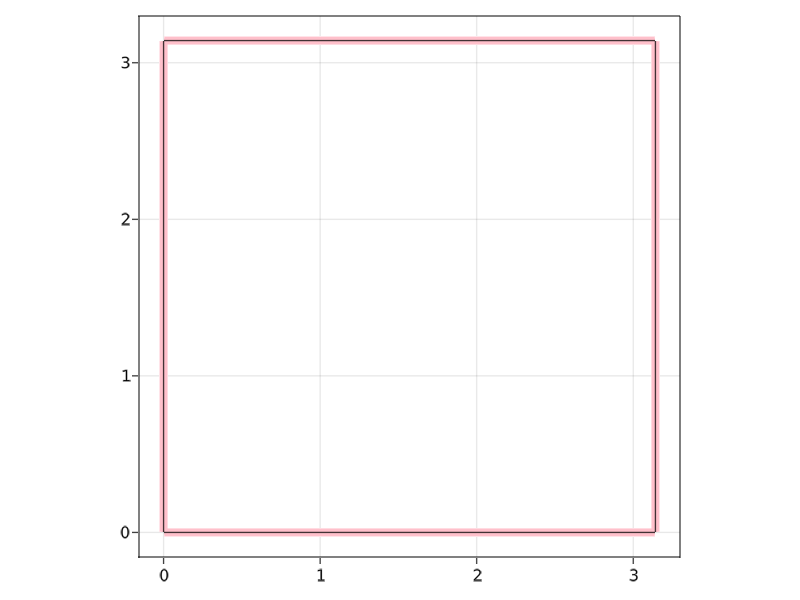

In [7]:
Γ = BoundaryTriangulation(model,tags=boundary_tags)
dΓ = Measure(Γ,degree)
fig, ax = plot(Γ, linewidth=8)
ax.aspect = AxisAspect(1)
wireframe!(Γ, color=:black, linewidth=1)
fig

In [8]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

In [9]:
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
m(u,v) = ∫(u*v)dΩ


m (generic function with 1 method)

In [10]:
include("eigen.jl")


solve (generic function with 1 method)

In [11]:
nev = 10 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev = nev)
ξ, uₕs = solve(prob);


We now can plot the eigen-functions. To do that we choose them using the index in which they are saved.

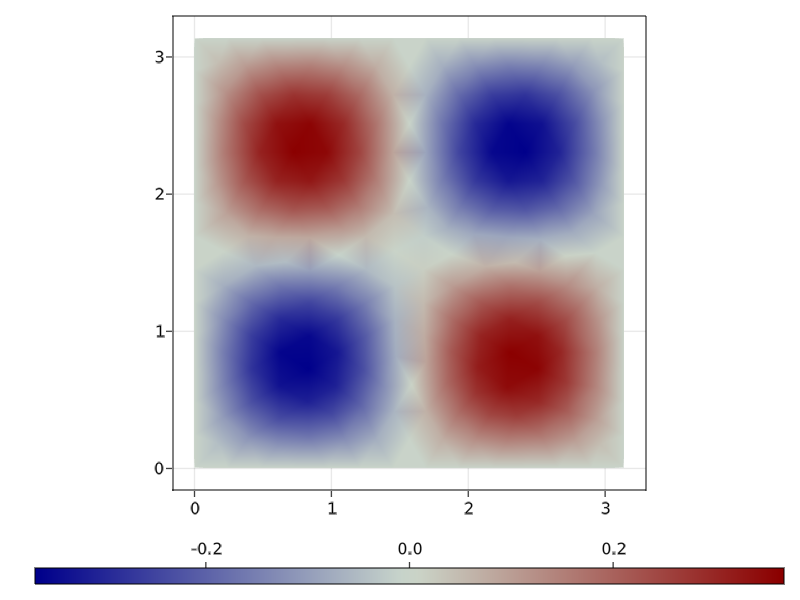

In [12]:
uₕ = uₕs[4]
fig, ax, plt = plot(Ω, real(uₕ))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

We can plot the eigenvalues:

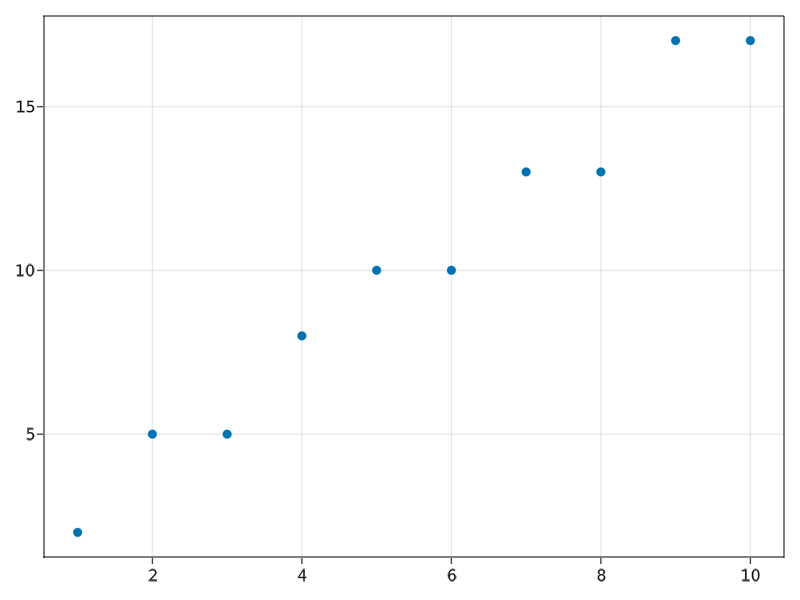

In [13]:
scatter(real(ξ))

In [14]:
ξ

10-element Vector{ComplexF64}:
 2.0000317185927665 - 6.773307151121268e-17im
  5.000478966241504 - 7.25447141793793e-17im
  5.000484821749061 + 6.330217906836288e-17im
  8.001970859986988 + 1.967059074924815e-16im
 10.003729490193692 - 1.686455819245031e-16im
 10.003772895897567 + 3.843434034117948e-16im
 13.008139245412337 - 3.8020345536934237e-16im
 13.008379356727371 + 2.1689377964183905e-16im
 17.017736137269175 + 1.3854268744663844e-15im
  17.01818222836105 - 1.1158186944018224e-15im

For the test case we can compare with the correct values.

In [15]:
if test 
    [n^2 + m^2 for n = 1:5, m = 1:5]
end

5×5 Matrix{Int64}:
  2   5  10  17  26
  5   8  13  20  29
 10  13  18  25  34
 17  20  25  32  41
 26  29  34  41  50

# Resolvamos el problema de una membrana circular vibrante

### Debemos resolver la ecuación de Ondas
### $$
\Big( \nabla^2-\frac{1}{c^2} \frac{\partial^2}{\partial t^2} \Big) \ u(\vec{r},t) = 0
$$

### Utilizando separación de variables:
### $$
u(\vec{r},t) = A(r,\theta) \ T(t)
$$

### $$
\frac{\nabla^2 A}{A} = \frac{1}{c^2 \ T} \frac{d^2 T}{d t^2} = -k^2  \ \ , \ \ k>0
$$

### $$
\big( \nabla^2+k^2 \big) \ A = 0
$$

### $$
\Big( \frac{d^2}{d t^2} + \omega^2 \Big) \ T = 0 \ \ , \ \ \omega = ck
$$


### Entonces debemos resolver la ecuación de Helmholtz
### $$
\big( \nabla^2+k^2 \big) \ A = 0
$$
### Donde tenemos condiciones de membrana sujeta
### $$
A(r=R_0,\theta) = 0
$$
### Adimensionalizando la variable radial
### $$
r = \frac{r}{R_0} \ \ , \ \ A(1,\theta) = 0
$$

### La formulación débil del problema es:
### $$
\int_{\Omega} \nabla A\,\cdot \nabla v\, {\rm d} x
= -k^2 \int_{\Omega} A \ v \ {\rm d} x \quad \forall  v \in H^1_0(\Omega)
$$

In [16]:
R0 = 1
h = 0.05
grid_type = "circle"
p = (R0, h)
boundary_tags = ["cir"]
dirichlet_tags= ["cir"]
dirichlet_values = 0.0
model = make_model(grid_type, p)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 50%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000996828s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0488923s, CPU 0.046875s)
Info    : 1597 nodes 3195 elements
Info    : Writing 'models/circle.msh'...
Info    : Done writing 'models/circle.msh'
Info    : Reading 'models/circle.msh'...
Info    : 10 entities
Info    : 1596 nodes
Info    : 3190 elements
Info    : Done reading 'models/circle.msh'


UnstructuredDiscreteModel()

In [17]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

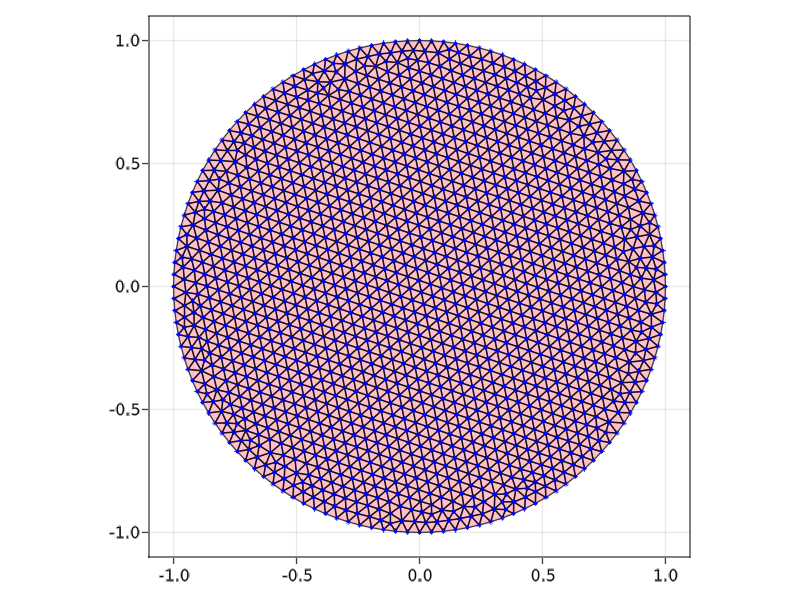

In [18]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

In [19]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)

TrialFESpace()

In [44]:
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
m(u,v) = ∫(u*v)dΩ

m (generic function with 1 method)

In [45]:
nev = 10 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev = nev, tol=10^(-6), maxiter=1000)
ξ, uₕs = solve(prob);

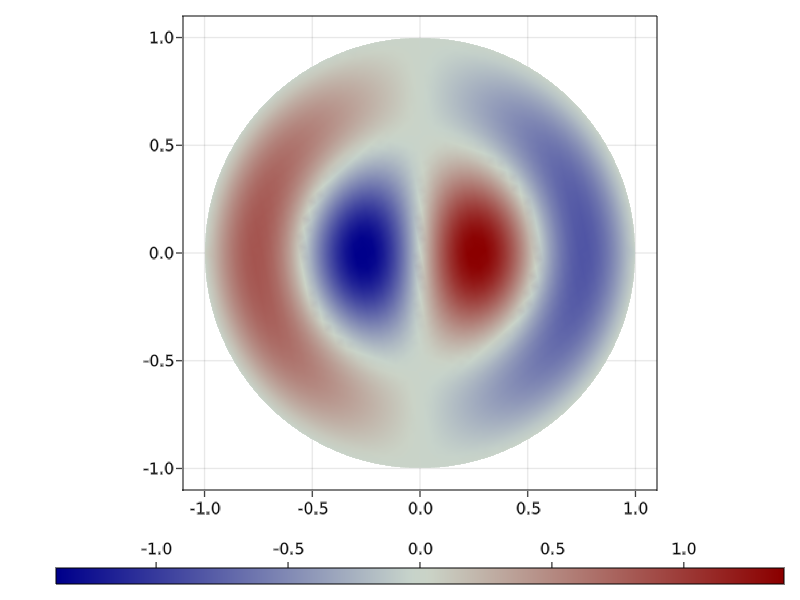

In [54]:
uₕ = uₕs[10]
fig, ax, plt = plot(Ω, real(uₕ))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

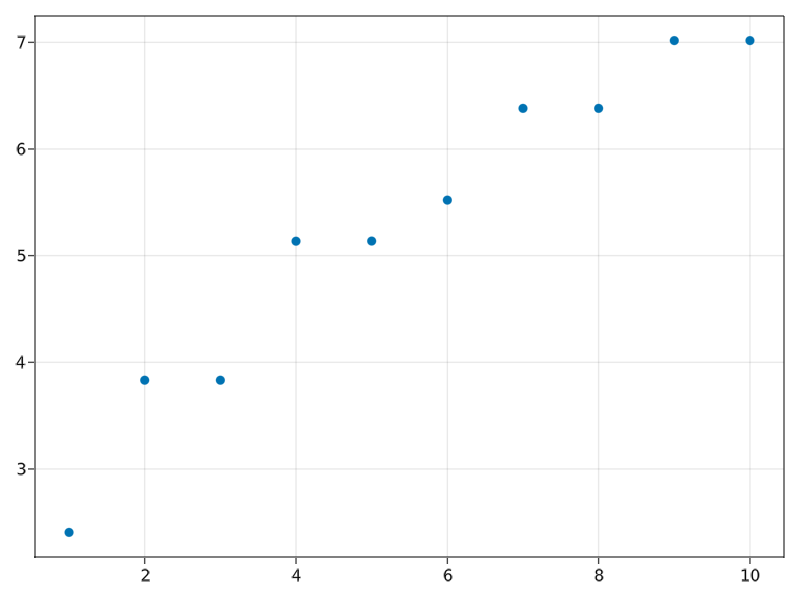

In [55]:
scatter(sqrt.(real(ξ)))

In [56]:
sqrt.(real.(ξ))

10-element Vector{Float64}:
 2.405029406718034
 3.832022249659182
 3.8320432404441855
 5.135456766571429
 5.13667876110176
 5.520561162527478
 6.380715335027894
 6.380751091808208
 7.0162150331140305
 7.016254526543047

### Aplicando separación de variables al problema
### $$
\big( \nabla^2+k^2 \big) \ A = 0
$$
### No es difícil ver que la solución se escribe como
### $$
u(r,\theta,t) = \sum_{n,m} C_{n,m} \ cos(c \ k_{n,m}\ t) \ J_m(k_{n,m} \ r) \ cos(m \theta)
$$
### $$
n=1,2,3,\dots \ \ \ \ m=0,1,2,3,\dots
$$
### Donde los coeficientes $C_{n,m}$ se determinan a partir de una condición inicial para $u$ 
### y $k_{n,m}$ es el enésimo cero de la función de Bessel de orden m


### Así, si la condición inicial coincide con uno de los modos vibracionales, digamos el $(n,m)=2,1$
### $$
u(r,\theta,t) = C_{2,1} \ cos(c \ k_{2,1}\ t) \ J_1(k_{2,1} \ r) \ cos( \theta)
$$

![Image](bessel_zeros.png) 

### $k_{2,1}=7.0156$

## Comparemos entonces con una solución exacta

In [57]:
using SpecialFunctions
function u21(x)
    rr=sqrt(x[1]^2+x[2]^2)
    cos_th=x[1]/rr
    return besselj(1,7.0156*rr)*cos_th
end

u21 (generic function with 1 method)

In [58]:
exact = interpolate_everywhere(u21,V);
writevtk(Ω,"images/exact",cellfields=["exact" => -real(exact)])
writevtk(Ω,"images/constructed",cellfields=["constructed" => real(uₕ)])

(["images/constructed.vtu"],)

### Solución exacta

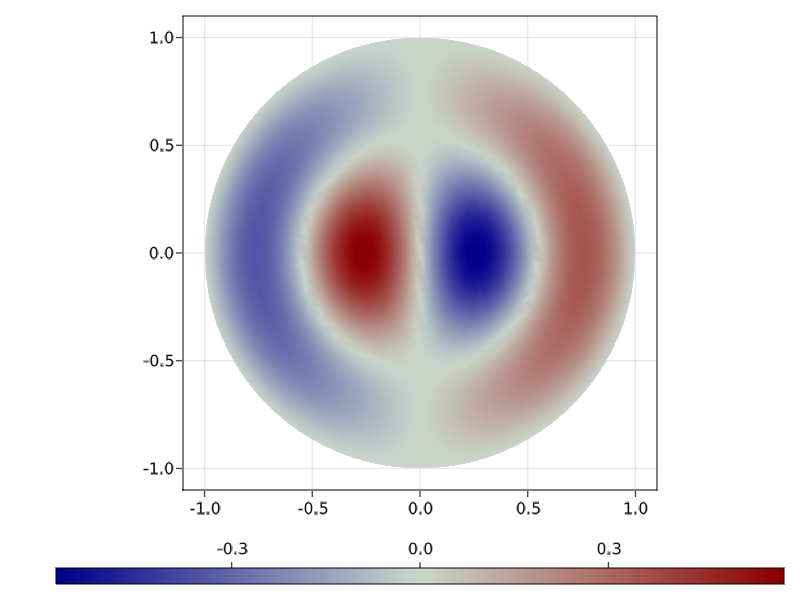

In [59]:
fig, ax, plt = plot(Ω, -real(exact))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

### Ploteamos el error $er=|u-u_{exc}|$
(Acá tuve que normalizar ambos modos, para poder compararlos)

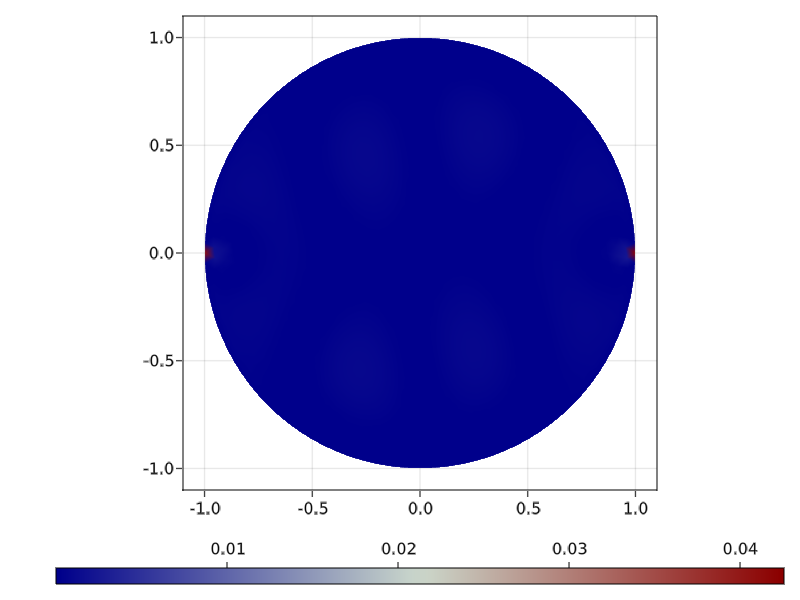

In [62]:
writevtk(Ω,"images/error",cellfields=["error" => abs(real(uₕ)/1.380-real(exact)/0.5797)])
fig, ax, plt = plot(Ω, abs(real(uₕ)/1.380-real(exact)/0.5797))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

In [64]:
Error=sqrt(sum(∫(abs(real(uₕ)/1.380-real(exact)/0.5797))dΩ))

0.04155889248756892

### Finalmente usando c=1 podemos dar una animación de la solución

In [39]:
T=8*pi/7.0156
num_steps=200
dt=T/num_steps
t=0
@time for istep in 1:num_steps
    writevtk(Ω,"images/constructed_sol_$(lpad(istep,3,'0'))",cellfields=["constructed_sol" => cos(7.0156*t)*real(uₕ)])
    t = t+dt
end

  1.501007 seconds (19.79 M allocations: 1.840 GiB, 21.00% gc time)


### Y una solución más general será una combinación lineal (que yo defino arbitrariamente, pero saldría de la condición inicial)

In [40]:
coef=[3.1,1.5,0.91,0.51,0.18]
knm=[sqrt(real(ξ[1])),sqrt(real(ξ[2])),sqrt(real(ξ[4])),sqrt(real(ξ[6])),sqrt(real(ξ[7]))]
T=5
num_steps=200
dt=T/num_steps
t=0
@time for istep in 1:num_steps
    writevtk(Ω,"images/constructed_sol_dos_$(lpad(istep,3,'0'))",cellfields=["constructed_sol_dos" => 
            coef[1]*cos(knm[1]*t)*real(uₕs[1])+coef[2]*cos(knm[2]*t)*real(uₕs[2])+coef[2]*cos(knm[2]*t)*real(uₕs[3])+
            coef[3]*cos(knm[3]*t)*real(uₕs[4])-coef[3]*cos(knm[3]*t)*real(uₕs[5])+coef[4]*cos(knm[4]*t)*real(uₕs[6])+
            coef[5]*cos(knm[5]*t)*real(uₕs[7])])
    t = t+dt
end

  3.912132 seconds (34.66 M allocations: 3.261 GiB, 13.26% gc time)
